In [7]:
!pip3 install foolbox==3.1.1

import matplotlib.pyplot as plt
import requests
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import foolbox as fb
import tensorflow as tf

img_path = 'image.png'

In [3]:
img_data = requests.get("https://c.pxhere.com/images/a3/c2/f0f92c545a6299eb6563f3213b04-1616104.jpg!d").content
#img_data = requests.get("https://upload.wikimedia.org/wikipedia/commons/0/09/Tux%2C_gray%EF%BC%8Fgrey_background.png").content
with open(img_path, 'wb') as handler:
    handler.write(img_data)

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n09428293', 'seashore', 0.29185417), ('n09421951', 'sandbar', 0.2565445), ('n04371774', 'swing', 0.15451878)]


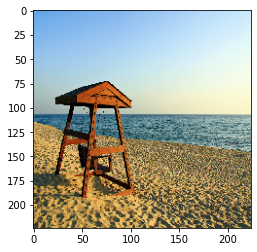

In [4]:
model = ResNet50(weights='imagenet')

img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [5]:
preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])
bounds = (0, 255)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

fmodel = fmodel.transform_bounds((0, 1))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [33]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

#plt.imshow(images[0])
print(images.shape)

print(labels.shape)
tf.print(labels)
tf.print(labels[0])

example_tensor = labels[0]

print(images.shape)

(16, 224, 224, 3)
(16,)
[243 559 438 ... 471 129 99]
243
(16, 224, 224, 3)


In [54]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)

# jak przetworzyć własny obrazek?

new_label = np.asarray([243]).astype(np.int32)
print(new_label.shape)

new_img = tf.keras.preprocessing.image.img_to_array(img)
new_img = np.asarray([new_img])
new_img = tf.convert_to_tensor(new_img, dtype=tf.float32)
print(new_img.shape)

# konwersja z formatu 0-255 do 0-1
new_img /= 255.0
print(new_img)

print(images[0])

# shape, typ zmiennej, kodowanie pikseli zgadzają się z tym co jest w images[]

raw, clipped, is_adv = attack(fmodel, new_img, new_label, epsilons=0.03)

(1,)
(1, 224, 224, 3)
tf.Tensor(
[[[[0.40392157 0.6431373  0.8901961 ]
   [0.39607844 0.64705884 0.8901961 ]
   [0.40392157 0.6431373  0.8980392 ]
   ...
   [0.79607844 0.9098039  0.98039216]
   [0.7921569  0.90588236 0.9764706 ]
   [0.8        0.9137255  0.9843137 ]]

  [[0.40392157 0.6431373  0.8901961 ]
   [0.39607844 0.64705884 0.8901961 ]
   [0.4        0.6392157  0.89411765]
   ...
   [0.79607844 0.9098039  0.98039216]
   [0.8        0.9137255  0.9843137 ]
   [0.8        0.9137255  0.9843137 ]]

  [[0.40392157 0.6431373  0.8901961 ]
   [0.39215687 0.6431373  0.8862745 ]
   [0.40392157 0.6431373  0.8980392 ]
   ...
   [0.79607844 0.9098039  0.972549  ]
   [0.79607844 0.9098039  0.972549  ]
   [0.8        0.9137255  0.9764706 ]]

  ...

  [[0.29411766 0.32156864 0.2509804 ]
   [0.24313726 0.30980393 0.27058825]
   [0.22352941 0.26666668 0.21176471]
   ...
   [0.7372549  0.62352943 0.34901962]
   [0.93333334 0.7176471  0.39607844]
   [0.6431373  0.5686275  0.34117648]]

  [[0.274509

TypeError: ignored

In [36]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [38]:
print(is_adv)
fb.distances.l2(images, raw)

tf.Tensor(
[False False False False False False False  True False False False False
 False False  True False], shape=(16,), dtype=bool)


<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([3.5195512e-01, 3.3622015e-01, 2.6489905e-01, 4.3962932e-01,
       6.5561628e-01, 7.7992898e-01, 1.5220782e-01, 9.5051051e-05,
       8.3996814e-01, 5.9477907e-01, 1.1025227e+00, 1.5672921e-01,
       2.8299087e-01, 6.6186124e-01, 5.2860323e-05, 4.1363168e-01],
      dtype=float32)>

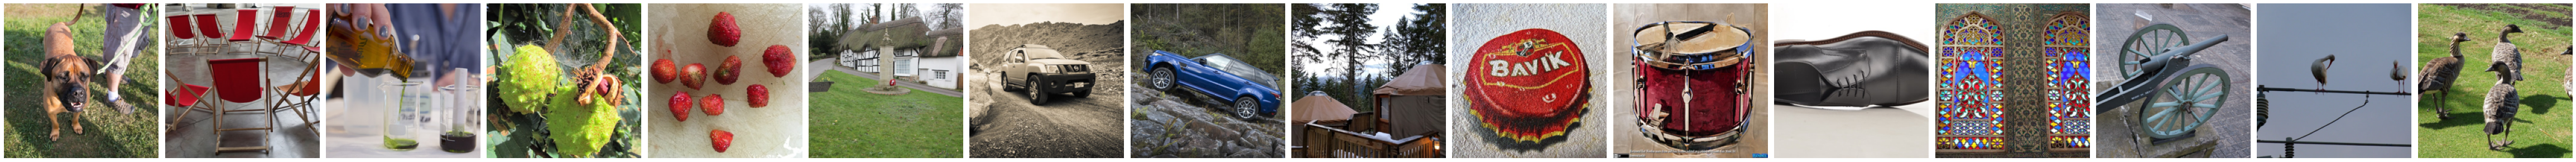

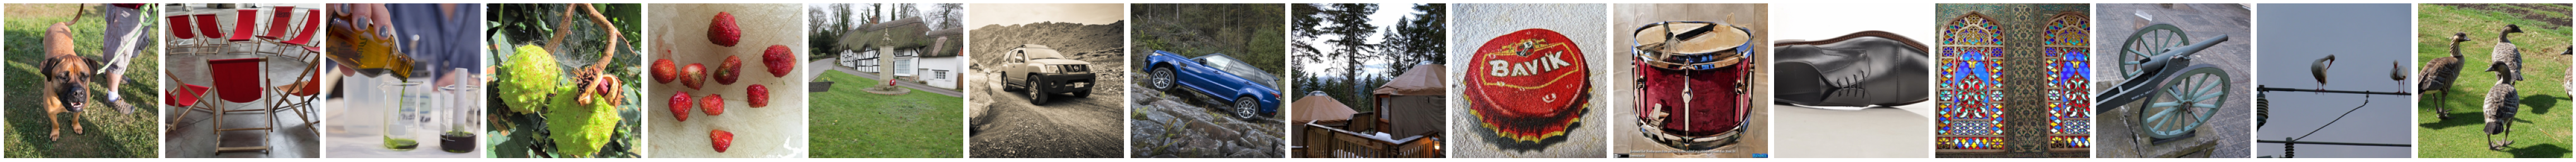

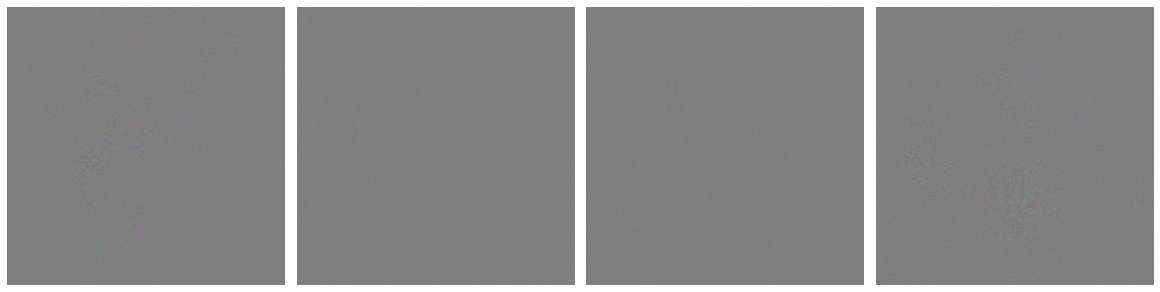

In [44]:
fb.plot.images(images, scale=4.)
fb.plot.images(raw, scale=4.)
fb.plot.images(raw - images, n=4, bounds=(-0.1, 0.1), scale=4.)